In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import skimage.feature
from skimage import color
from sklearn.decomposition import PCA
from sklearn import svm
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
#this displays a confusion matrix given the data and title
def show_cm(matrix, title):
    #the labels are 0-9
    labels = [i for i in range(10)]
    fig = plt.Figure()
    sns.heatmap(matrix,annot=True,cmap=plt.cm.RdPu)
    plt.title(title)
    
    plt.xticks(np.arange(len(labels)), labels)
    plt.yticks(np.arange(len(labels)), labels)
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [3]:
#import datasets
train_images = np.load('trnImage.npy')
test_images = np.load('tstImage.npy')
train_labels = np.load('trnLabel.npy')
test_labels = np.load('tstLabel.npy')

#transform image data
train_images = [train_images[:,:,:,i] for i in range(10000)]
test_images = [test_images[:,:,:,i] for i in range(1000)]

test_images = np.array(test_images)
train_images = np.array(train_images)

#compute HOG
test_hog_features = [skimage.feature.hog(i, pixels_per_cell=[2,2], cells_per_block=[3,3], visualize=False) for i in test_images]
train_hog_features = [skimage.feature.hog(i, pixels_per_cell=[2,2], cells_per_block=[3,3], visualize=False) for i in train_images]

test_hog_features = np.array(test_hog_features)
train_hog_features = np.array(train_hog_features)



#### PCA with NN

In [5]:
#Flatten data
train_images_flat = np.array(train_images) 
test_images_flat = np.array(test_images) 

train_images_flat = train_images.reshape(10000,-1)
test_images_flat = test_images.reshape(1000,-1)

#compute PCA
pca =PCA(n_components=0.9)
pca.fit(train_images_flat)

train_images_pca = pca.transform(train_images_flat)
test_images_pca = pca.transform(test_images_flat)

#Build Neural Network
model = models.Sequential()

#input layer with input shape, i.e. feature number
model.add(layers.Dense(128, activation='relu', input_shape=(97,)))
#hidden layer, take output from previous layer
model.add(layers.Dense(64, activation='relu'))
#dropout layer to randomly remove features
model.add(layers.Dropout(0.5))
#softmax layer to output our 10 categorisations
model.add(layers.Dense(10, activation='softmax'))
model.summary()
#use adam's optomiser
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#fit the model
history = model.fit(train_images_pca, train_labels, epochs=100, batch_size=128,
                   validation_data=(test_images_pca, test_labels))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               12544     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 21,450
Trainable params: 21,450
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
79/79 [==============================] - 0s 3ms/step - loss: 2.2541 - accuracy: 0.1890 - val_loss: 2.1872 - val_accuracy: 0.2740
Epoch 2/100
79/79 [==============================] - 0s 1ms/step - loss: 2.1779 - accuracy: 0.2819 - val_loss

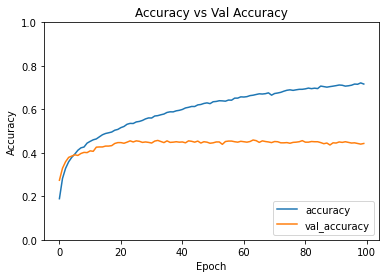

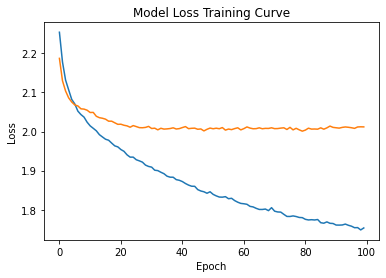

In [6]:
#plot accuracy and val accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title('Accuracy vs Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Plot the training curves for the model's loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss Training Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

32/32 [==============================] - 0s 469us/step - loss: 2.0119 - accuracy: 0.4430
images in category 0 were successfully identified with a percentage of: 55
images in category 1 were successfully identified with a percentage of: 49
images in category 2 were successfully identified with a percentage of: 27
images in category 3 were successfully identified with a percentage of: 29
images in category 4 were successfully identified with a percentage of: 44
images in category 5 were successfully identified with a percentage of: 38
images in category 6 were successfully identified with a percentage of: 50
images in category 7 were successfully identified with a percentage of: 45
images in category 8 were successfully identified with a percentage of: 61
images in category 9 were successfully identified with a percentage of: 45
the mean accuracy percentage is 44.3


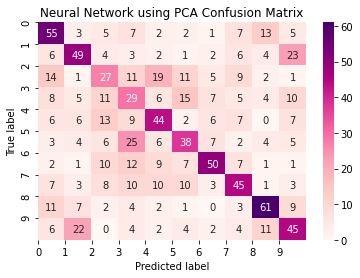

In [7]:
test_loss, test_acc = model.evaluate(test_images_pca,  test_labels)

predictions_prob = model.predict(test_images_pca)

#convert to real labels
predictions = []
for prediction in predictions_prob:
    predictions.append(np.argmax(prediction))
    
#create confusion matrix    
confusion = tf.math.confusion_matrix(
    labels=test_labels, predictions=predictions, num_classes=10, weights=None
)

#calculate accuracies from confusion matrix
accuracies = np.diagonal(confusion)
i = 0
for accuracy in accuracies:
    print("images in category " + str(i) + " were successfully identified with a percentage of: " + str(accuracy))
    i += 1
    

#show accuracies and confusion matrix
accuracy = np.mean(accuracies)
print("the mean accuracy percentage is " + str(accuracy))

show_cm(confusion, "Neural Network using PCA Confusion Matrix")

#### HOG with NN

In [16]:
model = models.Sequential()

#create neural network with input shape matching HOG features
model.add(layers.Dense(128, activation='relu', input_shape=(10000, 15876)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

#use adam's optomiser
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#fit the data to the model
history = model.fit(train_hog_features, train_labels, epochs=50, batch_size=128,
                   validation_data=(test_hog_features, test_labels))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 10000, 128)        2032256   
_________________________________________________________________
dense_9 (Dense)              (None, 10000, 64)         8256      
_________________________________________________________________
dropout_4 (Dropout)          (None, 10000, 64)         0         
_________________________________________________________________
dense_10 (Dense)             (None, 10000, 10)         650       
Total params: 2,041,162
Trainable params: 2,041,162
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
79/79 [==============================] - 1s 14ms/step - loss: 2.2220 - accuracy: 0.2257 - val_loss: 2.1123 - val_accuracy: 0.3530
Epoch 2/50
79/79 [==============================] - 1s 12ms/step - loss: 2.0957 - accuracy: 0.3686 - 

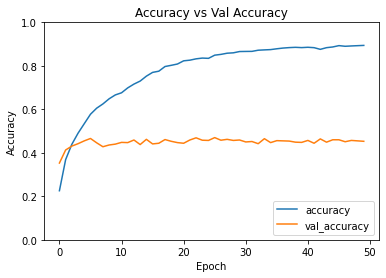

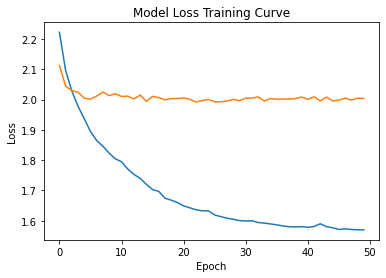

In [17]:
#plot accuracy and val accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title('Accuracy vs Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Plot the training curves for the model's loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss Training Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

32/32 [==============================] - 0s 2ms/step - loss: 2.0034 - accuracy: 0.4530
images in category 0 were successfully identified with a percentage of: 55
images in category 1 were successfully identified with a percentage of: 62
images in category 2 were successfully identified with a percentage of: 37
images in category 3 were successfully identified with a percentage of: 25
images in category 4 were successfully identified with a percentage of: 36
images in category 5 were successfully identified with a percentage of: 35
images in category 6 were successfully identified with a percentage of: 55
images in category 7 were successfully identified with a percentage of: 50
images in category 8 were successfully identified with a percentage of: 39
images in category 9 were successfully identified with a percentage of: 59
the mean accuracy percentage is 45.3


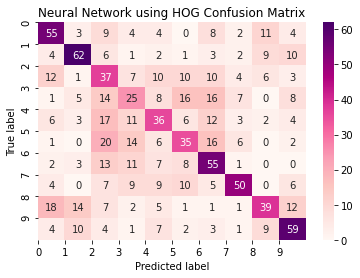

In [18]:
test_loss, test_acc = model.evaluate(test_hog_features,  test_labels)

#get label probability predictions
predictions_prob = model.predict(test_hog_features)

#convert to real labels
predictions = []
for prediction in predictions_prob:
    predictions.append(np.argmax(prediction))
    
#get confusion matrix of predicted labels    
confusion = tf.math.confusion_matrix(
    labels=test_labels, predictions=predictions, num_classes=10, weights=None
)

#calculate accuracies from confusion matrix
accuracies = np.diagonal(confusion)
i = 0
for accuracy in accuracies:
    print("images in category " + str(i) + " were successfully identified with a percentage of: " + str(accuracy))
    i += 1
    

#show accuracies and confusion matrix
accuracy = np.mean(accuracies)
print("the mean accuracy percentage is " + str(accuracy))

show_cm(confusion, "Neural Network using HOG Confusion Matrix")

#### SVM Using HOG

In [11]:
import datetime

begin_time = datetime.datetime.now()
print("started at: " + str(begin_time) + "     Expected End: " + str(begin_time + datetime.timedelta(minutes=36, seconds=6)) + "     Expected Runtime: 36min 06sec")
#create SVM
clf = svm.SVC()
#fit the data to the SVM, including flattening the label data
clf.fit(train_hog_features, train_labels.ravel())
#get predicted labels
prediction = clf.predict(test_hog_features)

end_time = datetime.datetime.now()
print("time taken is: " + str(end_time - begin_time))

started at: 2020-12-11 01:46:11.093517     Expected End: 2020-12-11 02:22:17.093517     Expected Runtime: 36min 06sec
time taken is: 0:33:34.693243


images in category 0 were successfully identified with a percentage of: 56
images in category 1 were successfully identified with a percentage of: 60
images in category 2 were successfully identified with a percentage of: 24
images in category 3 were successfully identified with a percentage of: 36
images in category 4 were successfully identified with a percentage of: 49
images in category 5 were successfully identified with a percentage of: 45
images in category 6 were successfully identified with a percentage of: 62
images in category 7 were successfully identified with a percentage of: 50
images in category 8 were successfully identified with a percentage of: 59
images in category 9 were successfully identified with a percentage of: 59
the mean accuracy percentage is 50.0


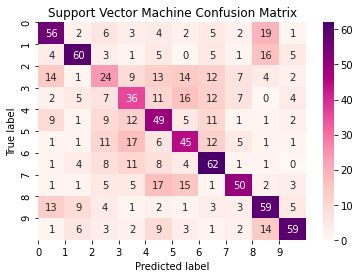

In [12]:
#create confusion matrix from predicted labels
confusion = tf.math.confusion_matrix(
    labels=test_labels, predictions=prediction, num_classes=10, weights=None
)

#calculate accuracy
accuracies = np.diagonal(confusion)
i = 0
for accuracy in accuracies:
    print("images in category " + str(i) + " were successfully identified with a percentage of: " + str(accuracy))
    i += 1
    

#display
accuracy = np.mean(accuracies)
print("the mean accuracy percentage is " + str(accuracy))

show_cm(confusion, "Support Vector Machine Confusion Matrix")

#### CNN

In [13]:
#create convoluted layers
model = models.Sequential()
#2 stages of feature extraction
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
#we can increase the number the more the dataset is downsampled
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#pool the result
model.add(layers.MaxPooling2D((2, 2)))
#apply dropout to randomly remove features
model.add(layers.Dropout(0.25))

#multiple convoluted stages
#model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#model.add(layers.Conv2D(128, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))

model.summary()
#flatten the output of the convultional layers (extracted features)
model.add(layers.Flatten())
#add a dense layer to pump the convoluted output into
model.add(layers.Dense(128, activation='relu'))
#model.add(layers.Dense(64, activation='relu'))
#agressive dropout to help with overfitting
model.add(layers.Dropout(0.5))
#output the classifications with softmax layer
model.add(layers.Dense(10, activation='softmax'))

#use adam's optomiser
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#fit the data to the model
history = model.fit(train_images, train_labels, epochs=100, batch_size=500, 
                    validation_data=(test_images, test_labels))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
Total params: 19,392
Trainable params: 19,392
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
20/20 [==============================] - 8s 386ms/step - loss: 2.2428 - accuracy: 0.1934 - val_loss: 2.1550 - val_accuracy: 0.3340
Epoch 2/100
20/20 [==============================] - 8s 395ms/step - loss: 2.1507 - accuracy: 0.3102 - va

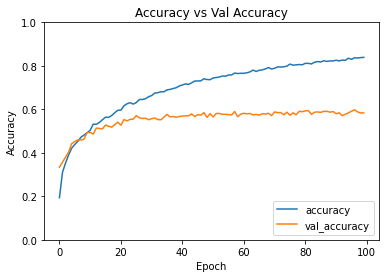

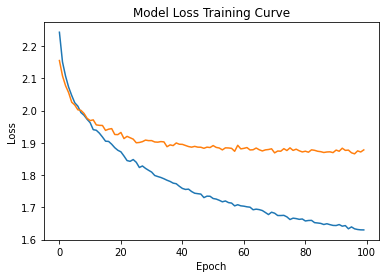

In [14]:
#plot the accuracy and val accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title('Accuracy vs Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Plot the training curves for the model's loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss Training Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

images in category 0 were successfully identified with a percentage of: 72
images in category 1 were successfully identified with a percentage of: 67
images in category 2 were successfully identified with a percentage of: 38
images in category 3 were successfully identified with a percentage of: 37
images in category 4 were successfully identified with a percentage of: 48
images in category 5 were successfully identified with a percentage of: 53
images in category 6 were successfully identified with a percentage of: 67
images in category 7 were successfully identified with a percentage of: 61
images in category 8 were successfully identified with a percentage of: 80
images in category 9 were successfully identified with a percentage of: 61
the mean accuracy percentage is 58.4


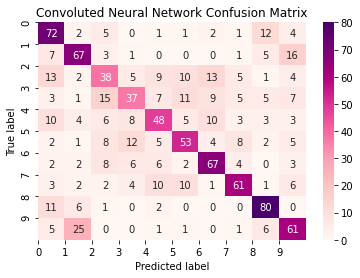

In [15]:
#predict label probabilities using the model
predictions_prob = model.predict(test_images)

#convert to real labels
predictions = []
for prediction in predictions_prob:
    predictions.append(np.argmax(prediction))
    
#create confusion matrix    
confusion = tf.math.confusion_matrix(
    labels=test_labels, predictions=predictions, num_classes=10, weights=None
)

#calculate averages
accuracies = np.diagonal(confusion)
i = 0
for accuracy in accuracies:
    print("images in category " + str(i) + " were successfully identified with a percentage of: " + str(accuracy))
    i += 1
    

#display
accuracy = np.mean(accuracies)
print("the mean accuracy percentage is " + str(accuracy))

show_cm(confusion, "Convoluted Neural Network Confusion Matrix")
 